In [36]:
import math
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy
import matplotlib.pyplot as plt
from scipy.stats import linregress
nlp = spacy.load("en_core_web_lg")

OUTPUT_DIR="../src/data"
SCHOOL="minnesota"
SUBJECT="opinion"
START_YEAR=2013
FINAL_YEAR=2022

In [37]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N,
            np.trace(cov)/N,
            np.linalg.norm(cov, ord=1)/N,
            np.linalg.norm(cov, ord=2)/N,
            np.linalg.norm(cov, ord=np.inf)/N,
            )

def cosine_distance(a, b):
    dot = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)

    # Calculate and return the cosine distance
    return 1 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

diversity_words = ['diversity', 'equity','inclusion','inclusive','inclusivity','equality', 'equal opportunity','social justice','racial justice','multi-cultural','multicultural','intercultural','intersectional', 'intersectionality','anti-discrimination']
diversity_pattern = "\b" + "|".join(diversity_words) + "\b"

english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                 for text in text_series])
    return text_series, total_diversity_words

In [38]:
results = []
for year in range(START_YEAR, FINAL_YEAR + 1):
    df = pd.read_parquet(f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-{year}.parquet")

    df['body_prepped'], num_diversity_words = prepText(df.body)
    wv = [nlp(s) for s in df['body_prepped']]
    docmatrix = np.array([v.vector for v in wv])

    cov = getCovDispersion(docmatrix)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    result = {'year': year,
              'pairwise': pairwise,
              'size': cov[0],
              'trace': cov[1],
              'norm-1': cov[2],
              'norm-2': cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm': num_diversity_words / cov[0]
              }
    results.append(result)
    print(f"{year}, {cov[0]}, {pairwise}")

results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')



2013, 8, 0.08418376956667219
2014, 3, 0.12212568521499634
2015, 36, 0.04278559646909199
2016, 125, 0.055769802439597345
2017, 303, 0.058672689798529486
2018, 329, 0.07605817824087342
2019, 282, 0.06289022185801797
2020, 280, 0.09320677323443305
2021, 210, 0.11244452872480556
2022, 212, 0.09924592080263804


,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2013,0.084184,8,1.476923,1.475304,1.364891,1.475304,2,0.250000
2014,0.122126,3,1.415122,1.381657,1.303160,1.381657,0,0.000000
2015,0.042786,36,1.598487,1.731891,1.541259,1.731891,1,0.027778
2016,0.055770,125,1.258435,1.367434,1.189301,1.367434,18,0.144000
2017,0.058673,303,1.299328,1.435125,1.223462,1.435125,88,0.290429
2018,0.076058,329,1.331562,1.427932,1.239091,1.427932,63,0.191489
2019,0.062890,282,1.321322,1.420432,1.240404,1.420432,83,0.294326
2020,0.093207,280,1.307490,1.421854,1.195199,1.421854,74,0.264286
2021,0.112445,210,1.260823,1.431978,1.131930,1.431978,33,0.157143


mentions-norm slope:0.00953, int:0.13225, r:0.27828, p:0.43625, se:0.01164, x:range(0, 10)
pairwise slope:0.00217, int:0.07096, r:0.25238, p:0.48176, se:0.00295, x:range(0, 10)


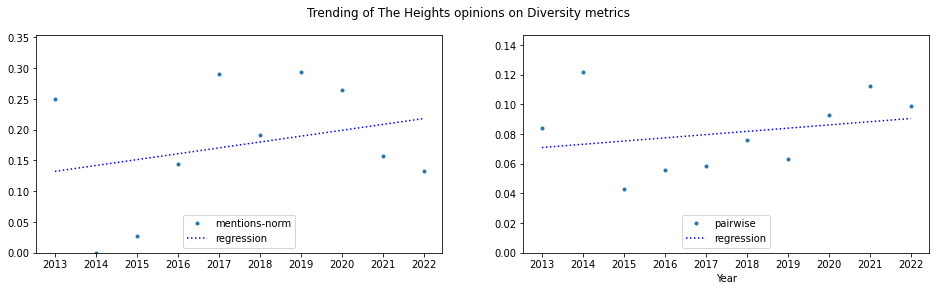

In [39]:
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16, 4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
        column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope * x, 'b:', label='regression')
    ax.set_ylim(0, max(y) * 1.2)

    # Add a legend
    ax.legend(loc='lower center')
    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

plt.xlabel("Year")
plt.suptitle("Trending of The Heights opinions on Diversity metrics")
plt.show()